In [52]:
import pandas as pd
import numpy as np

_m = pd.read_pickle('moonshot_submissions.p')

moonshot = _m.loc[_m.okay][['CID (canonical)','CID_group', 'old_index', 'clean_creator', 'SMILES', 'new_smiles',
                           'fragments', 'xcode', 'Structure ID', 'xcode','site_name', 'pdb_entry',
                            'ORDERED', 'MADE', 'ASSAYED', 'in_fragalysis',
                            'IC50', 'pIC50',
                           'submission_date', 'inferred_submission_date', 'order_date', 'shipment_date', 
                           'description', 'initial_screen',
                           'N_creator_submission', 'N_submission_group', 'resubmitted',
                           'Enamine - REAL Space', 'Enamine - Extended REAL Space',
                           'Enamine - SCR', 'Enamine - BB', 'Mcule', 'Mcule Ultimate',
                           'N_chars', 'N_words', 'N_words_cutoff', 'classified_method', 'flesch',
                           'dale_chall']]

del _m

moonshot['inferred_submission_month'] = moonshot.inferred_submission_date.apply(lambda d: d.month + 12 * (d.year -2020))
moonshot['pIC50'] = moonshot.IC50.apply(lambda i: -np.log10(i) + 6)

for j, i in enumerate(moonshot.index[moonshot.initial_screen]):
    moonshot.at[i, 'CID_group'] = f'DSi-poised-{j}'
    
# This set is some cryptic housekeeping by Aaron Morris
for  i in moonshot.index[moonshot.classified_method == 'INITIAL']:
    moonshot.at[i, 'classified_method'] = 'UNKNOWN'
    
moonshot['lucky_creator'] = moonshot.clean_creator.isin(['Matthew Robinson', 'Alpha Lee', 'Aaron Morris', 'DSi-Poised Library',
                                                         'Nir London', 'Lori Ferrins', 'Ruby Pai' 'Jin Pan', 'Aaron Keeley',
                                                         'Steven Verhelst', 'Anna Cederbalk', 'UNK UNK', 'UNK Cyclica',
                                                         'Redesign Science', 'Rodolfo Do Couto Maia', 'Dana Ferraris',
                                                         'Juan Salamanca Viloria'])

In [44]:
moonshot.classified_method.value_counts()

MANUAL_POSSIBLY         9288
DOCKING                 3116
MANUAL                  1420
FEP                      161
UNKNOWN                   56
PRIOR_SARS_INHIBITOR      41
STARTING_LIBRARY          40
Name: classified_method, dtype: int64

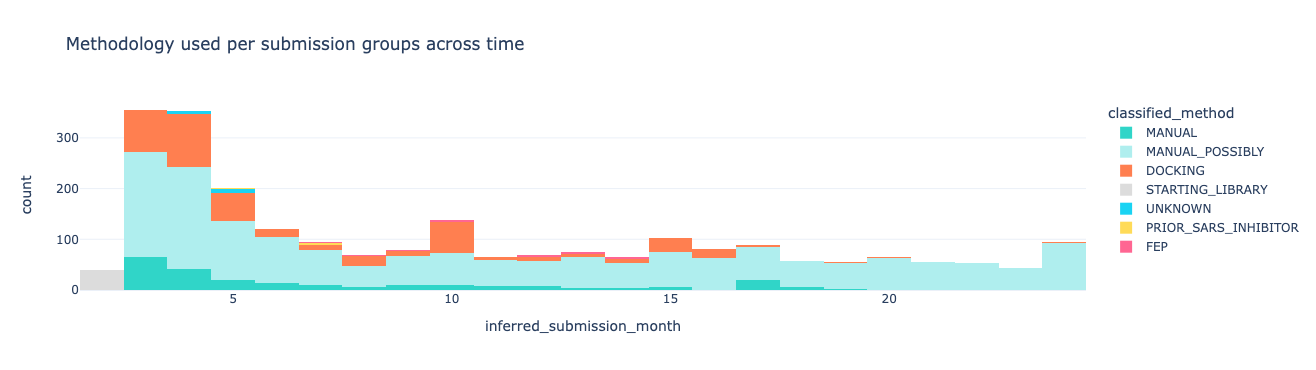

In [45]:
import plotly.express as px

fig = px.histogram(moonshot.drop_duplicates('CID_group'), 
                     'inferred_submission_month', 
                     color='classified_method',
                     color_discrete_map = {'DOCKING': '#ff7f50', 'MANUAL':'#30d5c8','MANUAL_POSSIBLY': '#afeeee',
                                           'PRIOR_SARS_INHIBITOR':'#ffdb58','STARTING_LIBRARY': 'gainsboro'},
                     title='Methodology used per submission groups across time',
                     template='plotly_white',
                    )
#fig.write_image("methodology_time.svg", width=800, height=800, scale=2)
fig

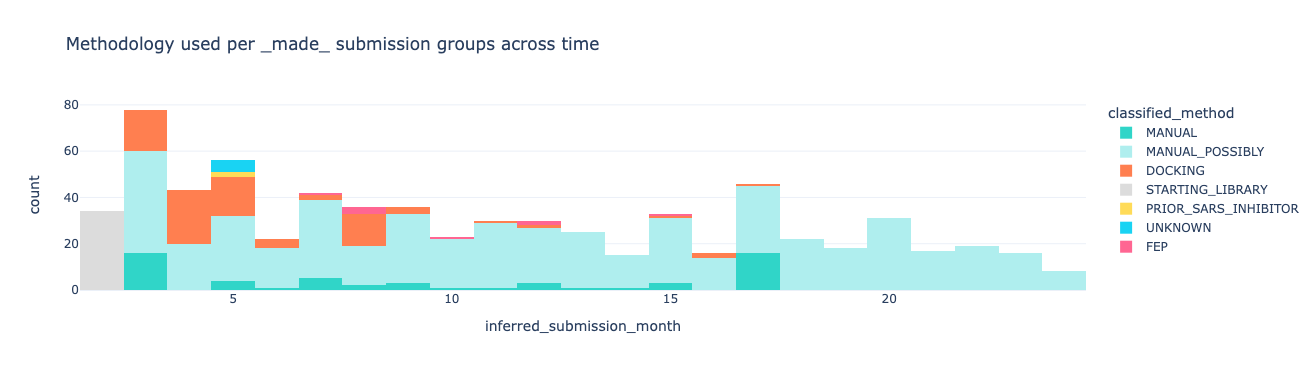

In [46]:
import plotly.express as px

fig = px.histogram(moonshot.loc[(moonshot.MADE)].drop_duplicates('CID_group'), 
                     'inferred_submission_month', 
                     color='classified_method',
                     color_discrete_map = {'DOCKING': '#ff7f50', 'MANUAL':'#30d5c8','MANUAL_POSSIBLY': '#afeeee',
                                           'PRIOR_SARS_INHIBITOR':'#ffdb58','STARTING_LIBRARY': 'gainsboro'},
                     title='Methodology used per _made_ submission groups across time',
                     template='plotly_white',
                    )
#fig.write_image("methodology_time.svg", width=800, height=800, scale=2)
fig

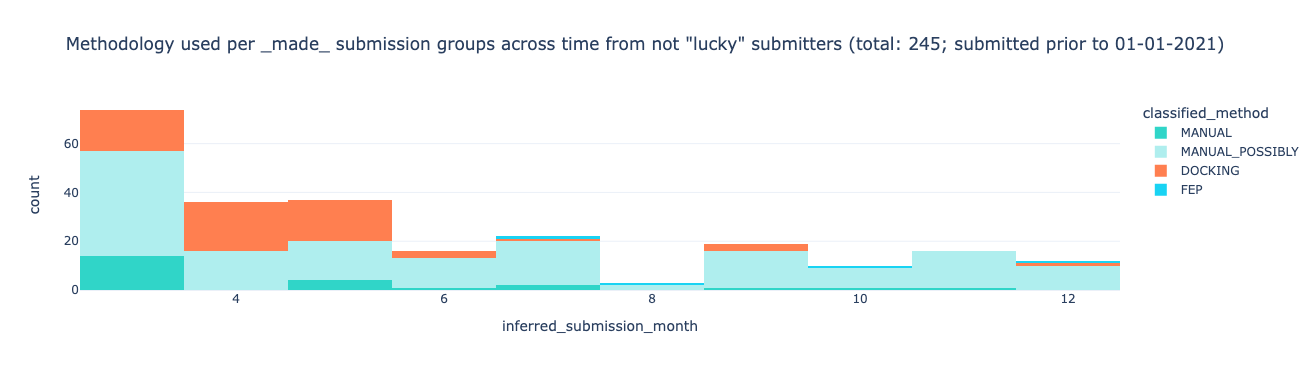

In [47]:
import plotly.express as px
from datetime import datetime

date_cutoff = datetime(2021, 1, 1)
subbed = moonshot.loc[(moonshot.MADE) & (~moonshot.lucky_creator) & (moonshot.inferred_submission_date < date_cutoff)].drop_duplicates('CID_group')

fig = px.histogram(subbed, 
                     'inferred_submission_month', 
                     color='classified_method',
                     color_discrete_map = {'DOCKING': '#ff7f50', 'MANUAL':'#30d5c8','MANUAL_POSSIBLY': '#afeeee',
                                           'PRIOR_SARS_INHIBITOR':'#ffdb58','STARTING_LIBRARY': 'gainsboro'},
                     title=f'Methodology used per _made_ submission groups across time from not "lucky" submitters (total: {len(subbed)}; submitted prior to {date_cutoff.strftime("%d-%m-%Y")})',
                     template='plotly_white',
                    )
#fig.write_image("methodology_time.svg", width=800, height=800, scale=2)
fig

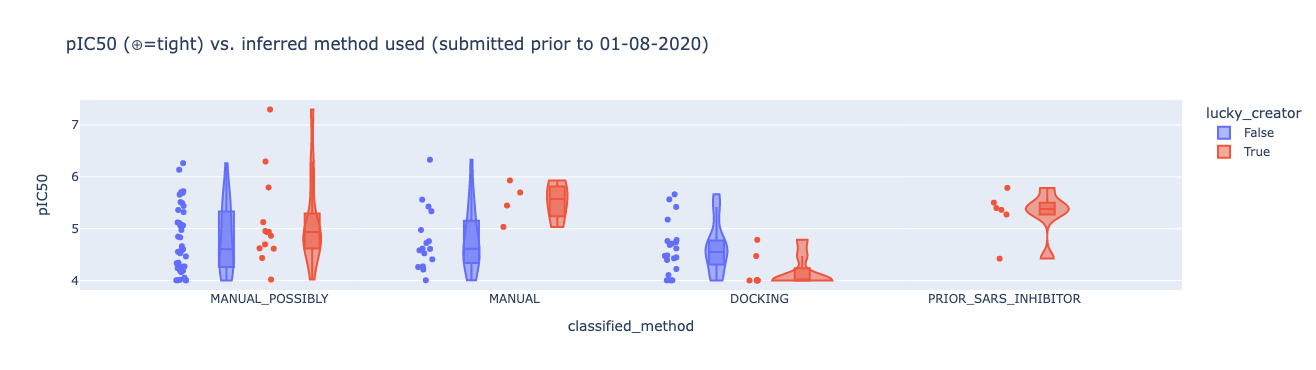

In [53]:
date_cutoff = datetime(2020, 8, 1)

subbed = moonshot.loc[~moonshot.classified_method.isin(['STARTING_LIBRARY', 'UNKNOWN']) & \
                      (moonshot.submission_date < date_cutoff) & (moonshot.shipment_date < date_cutoff)
                     ]
fig = px.violin(subbed,
                title=f'pIC50 ({chr(0x2295)}=tight) vs. inferred method used (submitted prior to {date_cutoff.strftime("%d-%m-%Y")})',
                y='pIC50', x='classified_method',
               color='lucky_creator',
               box=True,
               points='all')
fig.update_traces(spanmode = 'hard')
fig

In [54]:
moonshot.lucky_creator.value_counts()

False    11681
True      2441
Name: lucky_creator, dtype: int64

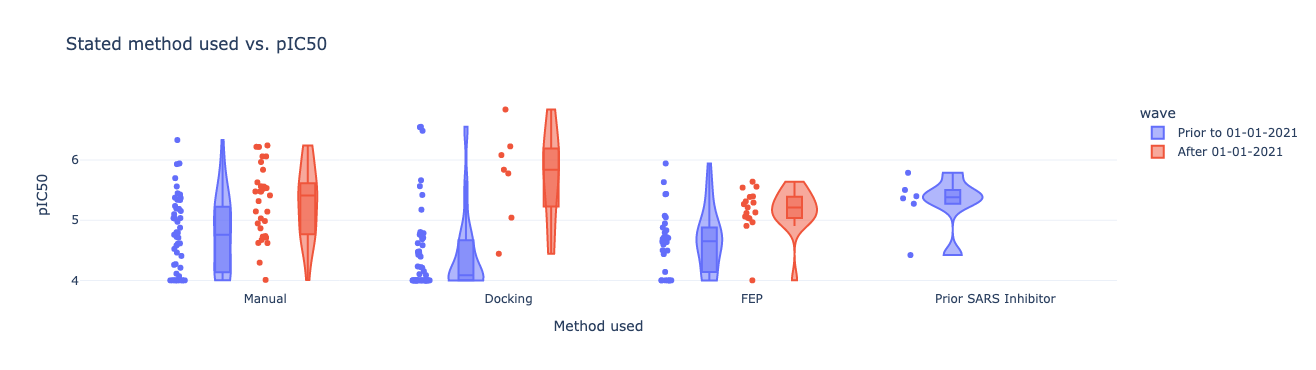

In [55]:
date_cutoff = datetime(2021, 1, 1)
moonshot['Method used'] = moonshot.classified_method.str.title().str.replace('_', ' ').str.replace('Sars', 'SARS').str.replace('Fep', 'FEP')
moonshot['wave'] =  ((moonshot.submission_date < date_cutoff) & (moonshot.shipment_date < date_cutoff)).map({True: f'Prior to {date_cutoff.strftime("%d-%m-%Y")}',
                                                                                                             False: f'After {date_cutoff.strftime("%d-%m-%Y")}'
                                                                                                             }
                                                                                                             )

subbed = moonshot.loc[~moonshot.classified_method.isin(['STARTING_LIBRARY', 'UNKNOWN', 'MANUAL_POSSIBLY'])]



fig = px.violin(subbed,
                template='plotly_white',
                title=f'Stated method used vs. pIC50',
                y='pIC50', x='Method used',
                #log_y=True,
               #color='lucky_creator',
               color='wave',
               category_orders={"Method used": ['Prior SARS Inhibitors', 'Manual', 'Docking', 'FEP'],
                               "wave": [f'Prior to {date_cutoff.strftime("%d-%m-%Y")}', f'After {date_cutoff.strftime("%d-%m-%Y")}'],
                               },
               box=True,
               points='all')
fig.update_traces(spanmode = 'hard')
fig.write_image("images/method_ic50.png", width=800, height=600, scale=2)
fig